# **Data analysis**

# **Environment Setup**

In [26]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd
from pathlib import Path

import os
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
import plotly.express as px
import numpy as np

import kaleido
from pathlib import Path
from scipy.integrate import simpson
import sq_fast


### **Style Setup**

In [102]:
plt.style.use('science.mplstyle')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral"
})

# Analysis

In [138]:
N_MAX = 20
MAX_FRAMES = 5_000

def get_simulation_parameters(filepath):
    params = {}
    keys = [
        "melting", "path", "N", "freeze_mc_steps", "alpha", "density", 
        "charge", "initial_temp", "final_temp", "temp_step"
    ]
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < len(keys):
                value = line.split('!')[0].strip()
                # Handle types properly
                if keys[i] == "melting" or keys[i] == "N":
                    params[keys[i]] = int(value)
                elif keys[i] == "path":
                    # Remove quotes if present
                    params[keys[i]] = value.strip('"').strip("'")
                else:
                    params[keys[i]] = float(value)
                
    return params

def structure_factor(L, simulation_path):
    n_range = np.arange(-N_MAX, N_MAX + 1)
    nx, ny, nz = np.meshgrid(n_range, n_range, n_range)
    n_vecs = np.vstack([nx.ravel(), ny.ravel(), nz.ravel()]).T
    n_vecs = n_vecs[np.any(n_vecs != 0, axis=1)] # Delete (0,0,0)
    
    q_vecs = (2.0 * np.pi / L) * n_vecs
    q_mags = np.linalg.norm(q_vecs, axis=1)
    
    # Fortran array preparation
    qx = np.ascontiguousarray(q_vecs[:, 0], dtype=np.float64)
    qy = np.ascontiguousarray(q_vecs[:, 1], dtype=np.float64)
    qz = np.ascontiguousarray(q_vecs[:, 2], dtype=np.float64)
    
    q, indices, counts = np.unique(np.round(q_mags, 4), return_inverse=True, return_counts=True)
    sq = np.zeros_like(q)
    
    num_frames = 0

    with open(simulation_path / "positions_t0.xyz", 'r') as f:
        while num_frames < MAX_FRAMES:
            line = f.readline()
            if not line: break
            try:
                N_atoms = int(line.strip())
                f.readline() 
                
                coords_raw = [f.readline().split() for _ in range(N_atoms)]
                coords = np.array(coords_raw)[:, 1:4].astype(np.float64)
                
                x = np.ascontiguousarray(coords[:, 0])
                y = np.ascontiguousarray(coords[:, 1])
                z = np.ascontiguousarray(coords[:, 2])

                sq_frame = sq_fast.sq_calc.compute_sq_kernel(x, y, z, qx, qy, qz)
                
                # Accumulate isotropic S(q)
                s_q_iso_frame = np.zeros_like(q)
                np.add.at(s_q_iso_frame, indices, sq_frame)
                sq += (s_q_iso_frame / counts)
                
                num_frames += 1

            except ValueError:
                break
    
    sq /= num_frames

    df = pd.DataFrame({'q': q, 'S(q)': sq})
    df.to_csv(simulation_path / "sq.csv", index=False)

    return q, sq



Processing T=0.0001
Processing T=0.001
Processing T=0.05
Processing T=0.09
Processing T=0.11
Processing T=0.12
Processing T=0.5
Processing T=1.0
Processing T=10


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5844/2193779415.py:18: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])


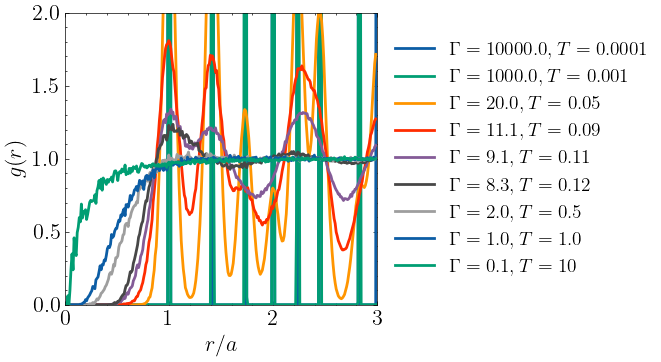

In [123]:
plt.figure(figsize=(7, 4))
gamma = lambda n, T : n**(1/3)/T
a_func = lambda rho : (1/rho)**(1/3)

T_list = [0.001, 0.01, 0.05, 0.1, 0.08, 0.09, 0.11, 0.12, 0.15, 0.2, 0.5, 1.0, 10]
T_list = [0.0001, 0.001,0.05, 0.09, 0.11, 0.12, 0.5, 1.0, 10]
T_step_list = [0.0001]*(len(T_list)-2) + [0.001, 0.1]

for T, T_step in zip(T_list,T_step_list):
    print(f"Processing T={T}")
    simulation_path = Path(f"output/n216_density1.00_t0.0001-{T}-{T_step}_melted")
    if T == 0.0001:
        simulation_path = Path(f"output/n216_density1.00_t1.0-0.0001-0.98")
    gdr_file = simulation_path / "rdf.out" 
    parameters_file = simulation_path / "input_parameters.in"
    parameters = get_simulation_parameters(parameters_file)

    df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])

    plt.plot(df['r']/a_func(1.0), df['gr'], label=rf'$\Gamma = {gamma(1, T):.1f}, T = {T}$', linewidth=2)
    plt.xlabel(r'$r/a$')
    plt.ylabel(r'$g(r)$')
    plt.ylim(0, 2)
    plt.xlim(0, 3)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()

In [139]:
L = (216/ 1)**(1/3)
for T, T_step in zip(T_list,T_step_list):
    print(f"Processing T={T}")
    simulation_path = Path(f"output/n216_density1.00_t0.0001-{T}-{T_step}_melted")
    if T == 0.0001:
        simulation_path = Path(f"output/n216_density1.00_t1.0-0.0001-0.98")

    q, sq = structure_factor(L=L, simulation_path=simulation_path)

Processing T=0.0001
Processing T=0.001
Processing T=0.05
Processing T=0.09
Processing T=0.11
Processing T=0.12
Processing T=0.5
Processing T=1.0
Processing T=10


<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5844/1352191146.py:37: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr'])


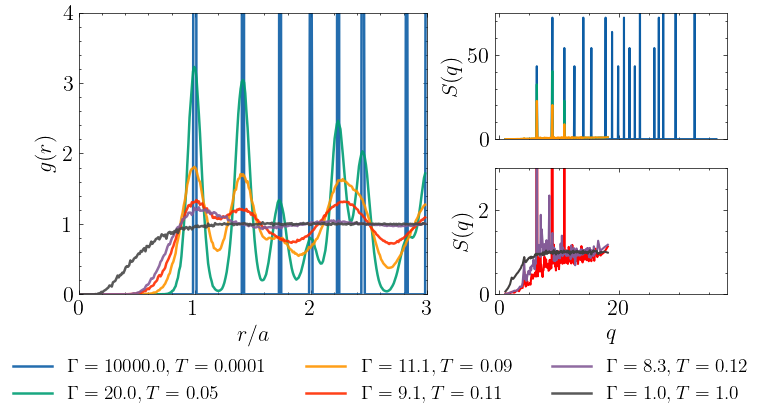

In [137]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14,})
# --- Helper functions ---
gamma = lambda n, T: n**(1/3)/T
a_func = lambda rho: (1/rho)**(1/3)

def get_simulation_parameters(file_path):
    return {} 

# --- Setup Data Parameters ---
# Unificamos todas las temperaturas únicas para asignar colores consistentes
T_rdf_list = [0.0001, 0.05, 0.09, 0.11, 0.12, 1.00]
T_sq_top = [0.0001, 0.09, 0.11]
T_sq_bottom = [0.11, 0.12, 1.00]

# --- Plotting ---
# Usamos constrained_layout para manejo automático de espacios
fig = plt.figure(figsize=(7, 3.5), constrained_layout=True)
gs = GridSpec(2, 2, width_ratios=[1.5, 1], figure=fig) # width_ratios 2:1 suele verse mejor

# 1. Panel Izquierdo: RDF
ax_rdf = fig.add_subplot(gs[:, 0])

# Listas auxiliares para la leyenda única
legend_handles = {}

for T in T_rdf_list:
    # Lógica de path (asumiendo tu estructura)
    T_step = 0.001 if T == 1 else 0.0001
    simulation_path = Path(f"output/n216_density1.00_t0.0001-{T}-{T_step}_melted")
    if T == 0.0001:
        simulation_path = Path(f"output/n216_density1.00_t1.0-0.0001-0.98")
    gdr_file = simulation_path / "rdf.out"
    
    try:
        # Intentar leer archivo
        if not gdr_file.exists(): raise FileNotFoundError
        df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr'])
        
        # Plot
        label_txt = rf'$\Gamma = {gamma(1, T):.1f}, T = {T}$'
        
        line, = ax_rdf.plot(df['r']/a_func(1.0), df['gr'], 
                            label=label_txt, linewidth=1.8, alpha=0.9)
        
        ax_rdf.set_xlim(0, 3)
        # Guardar handle para la leyenda global
        legend_handles[T] = line
        
    except (FileNotFoundError, pd.errors.EmptyDataError):
        print(f"Aviso: No se encontró o leyó {gdr_file}")

ax_rdf.set_xlabel(r'$r/a$')
ax_rdf.set_ylabel(r'$g(r)$')
ax_rdf.set_ylim(0, 4) # Ajustado un poco más alto para ver picos
# ax_rdf.grid(True, linestyle='--', alpha=0.4)

# 2. Panel Derecho Superior: S(q) Low T
ax_sq1 = fig.add_subplot(gs[0, 1])

for T in T_sq_top:
    T_step = 0.0001
    simulation_path = Path(f"output/n216_density1.00_t0.0001-{T}-{T_step}_melted")
    if T == 0.0001:
        simulation_path = Path(f"output/n216_density1.00_t1.0-0.0001-0.98")
    sq_file = simulation_path / "sq.csv"
    
    try:
        if not sq_file.exists(): raise FileNotFoundError
        df = pd.read_csv(sq_file, sep=',')
        ax_sq1.plot(df['q'], df['S(q)'], linewidth=1.5)
    except: pass

ax_sq1.set_ylabel(r'$S(q)$')
# ax_sq1.grid(True, linestyle='--', alpha=0.4)
ax_sq1.tick_params(labelbottom=False) # Ocultar etiquetas X del de arriba
ax_sq1.set_ylim(0, 75)
# 3. Panel Derecho Inferior: S(q) High T
ax_sq2 = fig.add_subplot(gs[1, 1], sharex=ax_sq1)

for T in T_sq_bottom:
    T_step = 0.001 if T == 1 else 0.0001
    simulation_path = Path(f"output/n216_density1.00_t0.0001-{T}-{T_step}_melted")
    sq_file = simulation_path / "sq.csv"
    
    try:
        if not sq_file.exists(): raise FileNotFoundError
        df = pd.read_csv(sq_file, sep=',')
        # Usamos get_color(T) para asegurar que sea el mismo gris que en el RDF si T=10
        if T == 1:
            color = "#423F3F"  # Gris oscuro para T=1
        if T == 0.11:
            color = 'red'
        if T == 0.12:
            color = "#845B97"

        ax_sq2.plot(df['q'], df['S(q)'], linewidth=1.5, color=color)
        ax_sq2.set_ylim(0, 3)
    except: pass

ax_sq2.set_xlabel(r'$q$')
ax_sq2.set_ylabel(r'$S(q)$')
# ax_sq2.grid(True, linestyle='--', alpha=0.4)

# --- Leyenda Global ---
# Ordenamos la leyenda por temperatura
sorted_T = sorted(legend_handles.keys())
handles = [legend_handles[t] for t in sorted_T]
labels = [h.get_label() for h in handles]

# Colocar leyenda debajo
fig.legend(handles, labels, loc='lower center', 
           bbox_to_anchor=(0.5, -0.2), # Coordenadas relativas (x, y) fuera del plot
           ncol=3, frameon=False)

# Guardar o mostrar
plt.savefig("rdf_sq.pdf", dpi=300, bbox_inches='tight') 
plt.show()